# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [173]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import scipy
from scipy.cluster import hierarchy as hc

In [174]:
# read in the json files
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
profiles = pd.read_json('data/profile.json', orient='records', lines=True)
events = pd.read_json('data/transcript.json', orient='records', lines=True)

In [175]:
def is_number(s):
    """Return true if `s` is a number"""
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def rf_feat_importance(m, X_test, y_test_preds):
    """Generate dataset with a column feature, feature importance and correlation."""
    cor = []
    for name, col in X_test.iteritems():
        cor.append(scipy.stats.spearmanr(col,np.round(y_test_preds)).correlation)
    return pd.DataFrame({'cols':X_test.columns, 'imp':m.feature_importances_, 'corr': cor}).sort_values('imp', ascending=False)

def plot_fi(fi):
    """Plot feature importance"""
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [176]:
offers

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [177]:
# remove list from the dataframe offers with one hot encoding
for channel in ['web', 'email', 'mobile', 'social']:
    offers['channel_'+ channel] = False
    for index, row in offers.iterrows():
        offers['channel_'+ channel][index] = channel in row['channels']            

/home/adrian/source/capstone-starbucks/.env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [178]:
offers = offers.drop('channels', axis=1)

In [179]:
offers

,reward,difficulty,duration,offer_type,id,channel_web,channel_email,channel_mobile,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,False,True,True,True
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,True,False,False
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True,True,True
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,False,True,True,True
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,True,True,True,True
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,True,True,True,False


In [180]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [181]:
profiles

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


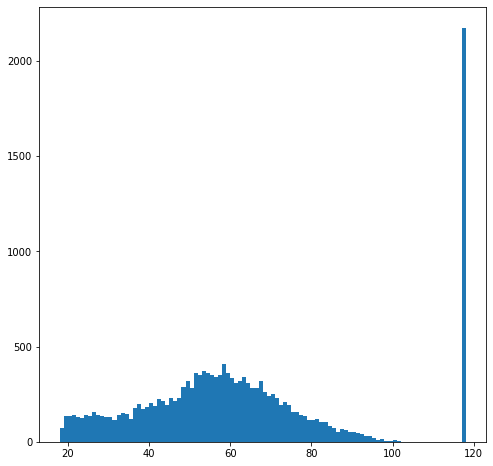

In [182]:
ax = profiles.age.hist(bins=100,figsize=[8,8],grid=False)
fig = ax.get_figure()
fig.savefig('age.png')

In [183]:
profiles['age'] = profiles.age.apply(lambda x: x if x is not 118 else np.nan)

In [184]:
1 - profiles.income.isnull().sum()/17000

0.8720588235294118

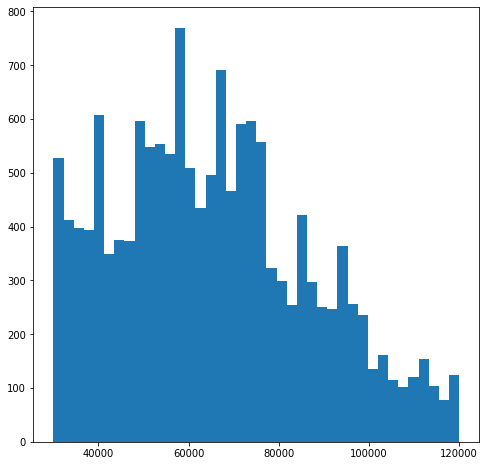

In [185]:
ax = profiles.income.hist(bins=40,figsize=[8,8],grid=False)
fig = ax.get_figure()
fig.savefig('income.png')

In [186]:
# convert became_member_on to datetime
profiles['became_member_on'] = profiles.became_member_on.apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
profiles['became_member_on'] = profiles.became_member_on.dt.day

In [187]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [188]:
events.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [189]:
events[events['event']=='transaction'].shape

(138953, 4)

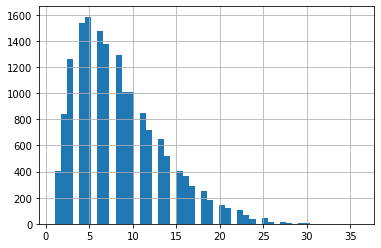

In [190]:
events[events['event']=='transaction'].groupby('person')['event'].count().hist(bins=50)

In [191]:
events['value'] = events.value.apply(lambda x: x['offer_id'] if x.get('offer_id') else (x['offer id'] if x.get('offer id') else x['amount']))

In [192]:
events['spent']= events['value'][events.value.apply(is_number)]

In [193]:
events['offer_type']= events['value'][~events.value.apply(is_number)]

In [194]:
df = events.merge(profiles, how='left', left_on='person', right_on='id')

In [195]:
df = df.drop(['id'],axis=1) 

In [196]:
df = df.merge(offers, how='left', left_on='value', right_on='id')

In [197]:
df = df.drop(['id','value'], axis=1)

In [198]:
nice_order = [
    'person',
    'time',
    'event',
    'spent',
    'offer_type_x',
    'age',
    'became_member_on',
    'gender',
    'income',
    'difficulty',
    'duration',
    'offer_type_y',
    'reward',
    'channel_web',
    'channel_email',
    'channel_mobile',
    'channel_social',
]
df = df.reindex(columns=nice_order)

In [199]:
df = df.sort_values(by=['person', 'time'])

In [200]:
df.head()

,person,time,event,spent,offer_type_x,age,became_member_on,gender,income,difficulty,duration,offer_type_y,reward,channel_web,channel_email,channel_mobile,channel_social
55972,0009655768c64bdeb2e877511632db8f,168,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,33.0,21,M,72000.0,0.0,3.0,informational,0.0,False,True,True,True
77705,0009655768c64bdeb2e877511632db8f,192,offer viewed,NaN,5a8bc65990b245e5a138643cd4eb9837,33.0,21,M,72000.0,0.0,3.0,informational,0.0,False,True,True,True
89291,0009655768c64bdeb2e877511632db8f,228,transaction,22.16,NaN,33.0,21,M,72000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,336,offer received,NaN,3f207df678b143eea3cee63160fa8bed,33.0,21,M,72000.0,0.0,4.0,informational,0.0,True,True,True,False
139992,0009655768c64bdeb2e877511632db8f,372,offer viewed,NaN,3f207df678b143eea3cee63160fa8bed,33.0,21,M,72000.0,0.0,4.0,informational,0.0,True,True,True,False


In [201]:
df[(df['event'] == 'offer received')&(df['offer_type_y'] != 'informational')].shape

(61042, 17)

In [202]:
df['person'] = df['person'].astype('category')
df['person'] = df['person'].cat.codes
df['duration'] = df.duration.apply(lambda x: int(x * 24) if pd.notna(x) else x)

In [203]:
df = df[df['offer_type_y'] != 'informational']

In [204]:
# check if offers do not overlap
current_person = -1
for index, row in df.iterrows():
    if row['person'] != current_person:
        current_person = row['person']
        current_offer_time = 0
        current_duration = 0
        
    if row['event'] == 'offer received':
        if row['time'] < current_offer_time + current_duration:
            print("Overlap at index {} and person {} with times {} < {}".format(index, row['person'], row['time'], current_offer_time + current_duration))
            break
        current_offer_time = row['time']
        current_duration = row['duration']
    elif row['event'] == 'offer completed':
        current_offer_time = 0
        current_duration = 0       

Overlap at index 204643 and person 2 with times 504 < 648.0


In [205]:
# offer received alternates with offer completed and offer viewed
current_person = -1
for index, row in df.iterrows():
    if row['person'] != current_person:
        offer_viewed = True
    if row['event'] == 'offer received':
        if not offer_viewed:
            print("Last offer was not viewed, a new one is already arriving.")
        offer_viewed = False
    elif row['event'] == 'offer viewed':
        offer_viewed = True

In [206]:
df['offer_type_x'] = df['offer_type_x'].astype('category')
df['offer_type_x'] = df['offer_type_x'].cat.codes

In [207]:
df.offer_type_x.unique()

array([-1,  6,  7,  2,  1,  0,  4,  5,  3])

In [208]:
df_additional = pd.DataFrame(
    {
        'offer_completed': pd.Series(False,index=df.index),
        'avg_spent': pd.Series(0,index=df.index),
        'avg_spent_over_time': pd.Series(0,index=df.index),
        'avg_till_viewed': pd.Series(0,index=df.index),
    })

In [209]:
current_person = -1
for index, row in df.iterrows():
    if row['person'] != current_person:
        current_person = row['person']
        first_time = row['time']
        total_spent = 0
        no_transactions = 0
        total_time_viewed = 0
        no_offers_viewed = 0
        
        last_offer_time = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        last_offer_index = [-1, -1, -1, -1, -1, -1, -1, -1, -1]
        last_offer_viewed = [False, False, False, False, False, False, False, False, False]
            
    if row['event'] == 'transaction':
        total_spent+=row['spent']
        no_transactions += 1
    elif row['event'] == 'offer received':
        last_offer_time[row['offer_type_x']] = row['time']
        last_offer_index[row['offer_type_x']] = index
    elif row['event'] == 'offer viewed':
        interval = row['time'] - last_offer_time[row['offer_type_x']]
        total_time_viewed += interval
        no_offers_viewed += 1
    elif row['event'] == 'offer completed':
        df_additional['offer_completed'].loc[last_offer_index[row['offer_type_x']]] = True
    if no_transactions:
        df_additional['avg_spent'].loc[index] = total_spent / no_transactions
    if row['time'] - first_time:
        df_additional['avg_spent_over_time'].loc[index] = total_spent / (row['time'] - first_time)
    if no_offers_viewed:
        df_additional['avg_till_viewed'].loc[index] = total_time_viewed / no_offers_viewed    

/home/adrian/source/capstone-starbucks/.env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [210]:
df_additional

,offer_completed,avg_spent,avg_spent_over_time,avg_till_viewed
89291,False,22.160000,0.000000,0.0
153401,True,22.160000,0.123111,0.0
168412,False,15.365000,0.165215,0.0
168413,False,15.365000,0.165215,0.0
187554,False,15.365000,0.134781,48.0
...,...,...,...,...
258361,False,15.156923,0.342083,13.2
258362,False,15.156923,0.342083,13.2
262475,False,15.156923,0.338557,12.0
274809,False,14.797143,0.341848,12.0


In [211]:
df = df.join(df_additional)

In [212]:
df = df[df['event']=='offer received']

In [213]:
df

,person,time,event,spent,offer_type_x,age,became_member_on,gender,income,difficulty,...,offer_type_y,reward,channel_web,channel_email,channel_mobile,channel_social,offer_completed,avg_spent,avg_spent_over_time,avg_till_viewed
153401,0,408,offer received,NaN,6,33.0,21,M,72000.0,5.0,...,bogo,5.0,True,True,True,True,True,22.160000,0.123111,0.0
204340,0,504,offer received,NaN,7,33.0,21,M,72000.0,10.0,...,discount,2.0,True,True,True,True,True,15.365000,0.111341,48.0
247879,0,576,offer received,NaN,2,33.0,21,M,72000.0,10.0,...,discount,2.0,True,True,True,False,True,14.600000,0.167816,42.0
56475,1,168,offer received,NaN,6,NaN,25,None,NaN,5.0,...,bogo,5.0,True,True,True,True,False,0.000000,0.000000,0.0
248359,1,576,offer received,NaN,6,NaN,25,None,NaN,5.0,...,bogo,5.0,True,True,True,True,False,1.363333,0.010025,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54574,16999,168,offer received,NaN,0,45.0,25,F,62000.0,20.0,...,discount,5.0,True,True,False,False,True,10.786667,0.192619,6.0
112214,16999,336,offer received,NaN,2,45.0,25,F,62000.0,10.0,...,discount,2.0,True,True,True,False,True,16.091250,0.383125,6.0
152030,16999,408,offer received,NaN,2,45.0,25,F,62000.0,10.0,...,discount,2.0,True,True,True,False,True,16.033333,0.353676,10.0
202962,16999,504,offer received,NaN,4,45.0,25,F,62000.0,5.0,...,bogo,5.0,True,True,True,False,True,15.910909,0.347262,9.0


In [214]:
df['spent'] = df.drop('spent', axis=1)

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61042 entries, 153401 to 246495
Data columns (total 21 columns):
person                 61042 non-null int16
time                   61042 non-null int64
event                  61042 non-null object
spent                  61042 non-null object
offer_type_x           61042 non-null int8
age                    53201 non-null float64
became_member_on       61042 non-null int64
gender                 53201 non-null object
income                 53201 non-null float64
difficulty             61042 non-null float64
duration               61042 non-null float64
offer_type_y           61042 non-null object
reward                 61042 non-null float64
channel_web            61042 non-null object
channel_email          61042 non-null object
channel_mobile         61042 non-null object
channel_social         61042 non-null object
offer_completed        61042 non-null bool
avg_spent              61042 non-null float64
avg_spent_over_time    61042 no

In [216]:
df['offer_completed'].sum()

33101

In [217]:
df = df.drop(['person','time','event'],axis=1)

In [218]:
df

,spent,offer_type_x,age,became_member_on,gender,income,difficulty,duration,offer_type_y,reward,channel_web,channel_email,channel_mobile,channel_social,offer_completed,avg_spent,avg_spent_over_time,avg_till_viewed
153401,0,6,33.0,21,M,72000.0,5.0,120.0,bogo,5.0,True,True,True,True,True,22.160000,0.123111,0.0
204340,0,7,33.0,21,M,72000.0,10.0,240.0,discount,2.0,True,True,True,True,True,15.365000,0.111341,48.0
247879,0,2,33.0,21,M,72000.0,10.0,168.0,discount,2.0,True,True,True,False,True,14.600000,0.167816,42.0
56475,1,6,NaN,25,None,NaN,5.0,120.0,bogo,5.0,True,True,True,True,False,0.000000,0.000000,0.0
248359,1,6,NaN,25,None,NaN,5.0,120.0,bogo,5.0,True,True,True,True,False,1.363333,0.010025,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54574,16999,0,45.0,25,F,62000.0,20.0,240.0,discount,5.0,True,True,False,False,True,10.786667,0.192619,6.0
112214,16999,2,45.0,25,F,62000.0,10.0,168.0,discount,2.0,True,True,True,False,True,16.091250,0.383125,6.0
152030,16999,2,45.0,25,F,62000.0,10.0,168.0,discount,2.0,True,True,True,False,True,16.033333,0.353676,10.0
202962,16999,4,45.0,25,F,62000.0,5.0,168.0,bogo,5.0,True,True,True,False,True,15.910909,0.347262,9.0


In [219]:
df['offer_type_y'] = df['offer_type_y'].astype('category')
df['offer_type_y'] = df['offer_type_y'].cat.codes
df['gender'] = df['gender'].astype('category')
df['gender'] = df['gender'].cat.codes

In [220]:
df

,spent,offer_type_x,age,became_member_on,gender,income,difficulty,duration,offer_type_y,reward,channel_web,channel_email,channel_mobile,channel_social,offer_completed,avg_spent,avg_spent_over_time,avg_till_viewed
153401,0,6,33.0,21,1,72000.0,5.0,120.0,0,5.0,True,True,True,True,True,22.160000,0.123111,0.0
204340,0,7,33.0,21,1,72000.0,10.0,240.0,1,2.0,True,True,True,True,True,15.365000,0.111341,48.0
247879,0,2,33.0,21,1,72000.0,10.0,168.0,1,2.0,True,True,True,False,True,14.600000,0.167816,42.0
56475,1,6,NaN,25,-1,NaN,5.0,120.0,0,5.0,True,True,True,True,False,0.000000,0.000000,0.0
248359,1,6,NaN,25,-1,NaN,5.0,120.0,0,5.0,True,True,True,True,False,1.363333,0.010025,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54574,16999,0,45.0,25,0,62000.0,20.0,240.0,1,5.0,True,True,False,False,True,10.786667,0.192619,6.0
112214,16999,2,45.0,25,0,62000.0,10.0,168.0,1,2.0,True,True,True,False,True,16.091250,0.383125,6.0
152030,16999,2,45.0,25,0,62000.0,10.0,168.0,1,2.0,True,True,True,False,True,16.033333,0.353676,10.0
202962,16999,4,45.0,25,0,62000.0,5.0,168.0,0,5.0,True,True,True,False,True,15.910909,0.347262,9.0


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61042 entries, 153401 to 246495
Data columns (total 18 columns):
spent                  61042 non-null object
offer_type_x           61042 non-null int8
age                    53201 non-null float64
became_member_on       61042 non-null int64
gender                 61042 non-null int8
income                 53201 non-null float64
difficulty             61042 non-null float64
duration               61042 non-null float64
offer_type_y           61042 non-null int8
reward                 61042 non-null float64
channel_web            61042 non-null object
channel_email          61042 non-null object
channel_mobile         61042 non-null object
channel_social         61042 non-null object
offer_completed        61042 non-null bool
avg_spent              61042 non-null float64
avg_spent_over_time    61042 non-null float64
avg_till_viewed        61042 non-null float64
dtypes: bool(1), float64(8), int64(1), int8(3), object(5)
memory usage: 7.2+

In [222]:
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
df = df.apply(fill_mean, axis=0)

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61042 entries, 153401 to 246495
Data columns (total 18 columns):
spent                  61042 non-null int64
offer_type_x           61042 non-null int8
age                    61042 non-null float64
became_member_on       61042 non-null int64
gender                 61042 non-null int8
income                 61042 non-null float64
difficulty             61042 non-null float64
duration               61042 non-null float64
offer_type_y           61042 non-null int8
reward                 61042 non-null float64
channel_web            61042 non-null bool
channel_email          61042 non-null bool
channel_mobile         61042 non-null bool
channel_social         61042 non-null bool
offer_completed        61042 non-null bool
avg_spent              61042 non-null float64
avg_spent_over_time    61042 non-null float64
avg_till_viewed        61042 non-null float64
dtypes: bool(5), float64(8), int64(2), int8(3)
memory usage: 5.6 MB


In [224]:
X = df.drop(['offer_completed'], axis=1)
y = df['offer_completed']
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.25, random_state=42)

In [225]:
# Grid search for good parameters, I used the mean absolute error as the main measure of quality
param_grid = {'min_samples_leaf': [15,20,25,30],'max_features': [7,8,9,10,11,'auto']}
grid = GridSearchCV(RandomForestRegressor(n_estimators=100,n_jobs=-1, oob_score=True), param_grid=param_grid,
                    scoring='neg_mean_absolute_error',cv=5, return_train_score=True)
X_train_grit = X_train.sample(frac=0.5, random_state=42)
grid.fit(X_train_grit, y_train.loc[X_train_grit.index])
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: -0.330
best parameters: {'max_features': 'auto', 'min_samples_leaf': 15}
test-set score: -0.324


In [226]:
# Out of performance reasons I used mean squared error, which is equal to variance reduction as feature selection criterion
model = RandomForestRegressor(n_estimators=250, n_jobs=-1,oob_score=True, min_samples_leaf=grid.best_params_['min_samples_leaf'], max_features=grid.best_params_['max_features'])
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=15,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [227]:
# Out of performance reasons I used mean squared error, which is equal to variance reduction as feature selection criterion
model= RandomForestRegressor(n_estimators=2000, n_jobs=-1,oob_score=True,min_samples_leaf=20,max_features=8, )
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [228]:
model.score(X_test,y_test)

0.35771408221263556

In [229]:
model.score(X_valid,y_valid)

0.3542722483677605

In [230]:
fi = rf_feat_importance(model, X_test, model.predict(X_test)); fi

/home/adrian/source/capstone-starbucks/.env/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/adrian/source/capstone-starbucks/.env/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/adrian/source/capstone-starbucks/.env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/adrian/source/capstone-starbucks/.env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/adrian/source/capstone-starbucks/.env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,cols,imp,corr
14,avg_spent,0.332323,0.510868
15,avg_spent_over_time,0.216898,0.499148
5,income,0.106895,0.382083
4,gender,0.085185,0.101161
0,spent,0.045039,0.021304
2,age,0.041516,0.183523
9,reward,0.036215,-0.115318
16,avg_till_viewed,0.030762,0.020569
3,became_member_on,0.029566,-0.001484
6,difficulty,0.024793,-0.067597


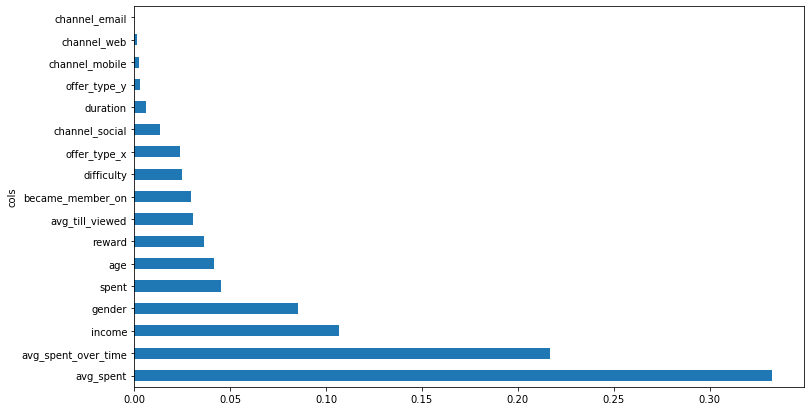

In [231]:
plot = plot_fi(fi)
fig = plot.get_figure()
fig.savefig("feature_importance.png",dpi=800)